In [ ]:
''' 
Using the output file from ~/preprocessing/preprocessing.ipynb, 
'''

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# sns.set_style("whitegrid")

In [ ]:
PATH_TO_KINKER_ADATA = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/adata_k.preprocessed.NanoMnT.h5ad'
PATH_TO_KINKER_METADATA = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/Kinker_et_al.MSI_metadata.tsv'

adata = sc.read_h5ad(PATH_TO_KINKER_ADATA)
MSI_metadata = pd.read_csv(PATH_TO_KINKER_METADATA, sep='\t')

## Visualize MSI score through TSNE (Fig. 1b, Extended Data Fig. 1a)

In [3]:
MSI_metadata = MSI_metadata[(MSI_metadata['MSI status'].isin(['MSI', 'MSI-L', 'MSS']))]

dict_cellline_to_msi = { list(tup)[2] : list(tup)[3] for tup in MSI_metadata.itertuples() }

In [4]:
adata.obs['CellLine_Name'] = [ CellLine.split('_')[0] for CellLine in adata.obs['CellLine'] ]
adata.obs.head(2)

CB       CellLine PoolID   CancerType  n_genes  \
0  AAACCTGAGACATAAC-1-18  NCIH2126_LUNG     18  Lung Cancer     4318   
1  AACGTTGTCACCCGAG-1-18  NCIH2126_LUNG     18  Lung Cancer     5200   

            Identifier  AvgSTRDiff  StdSTRDiff  NumSTRLoci  MSI_score  \
0  AAACCTGAGACATAAC-18   -0.145833    2.491566          96   0.363353   
1  AACGTTGTCACCCGAG-18    0.040816    2.079631          98  -0.084883   

  CellLine_Name  
0      NCIH2126  
1      NCIH2126

In [5]:
adata_MSI = adata[(adata.obs['CellLine_Name'].isin( MSI_metadata['Cell line'] )) & (adata.obs['NumSTRLoci']>=10)].copy()
print(adata_MSI.shape)
adata_MSI = adata_MSI.raw.to_adata()

adata_MSI.obs['MSI_GroundTruth'] = [ dict_cellline_to_msi[CellLine] for CellLine in adata_MSI.obs['CellLine_Name'] ]

sc.pp.highly_variable_genes(adata_MSI, n_top_genes=2000, batch_key="PoolID")

adata_MSI.raw = adata_MSI.copy()
adata_MSI = adata_MSI[:, adata_MSI.var.highly_variable]

sc.pp.scale(adata_MSI, max_value=10)
sc.tl.pca(adata_MSI, svd_solver="arpack")

sc.pp.neighbors(adata_MSI, n_neighbors=15, n_pcs=40)
sc.tl.tsne(adata_MSI)

(7019, 2000)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-04-10 17:23:13.140307: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 17:23:13.144121: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 17:23:13.148128: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 17:23:13.158910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 

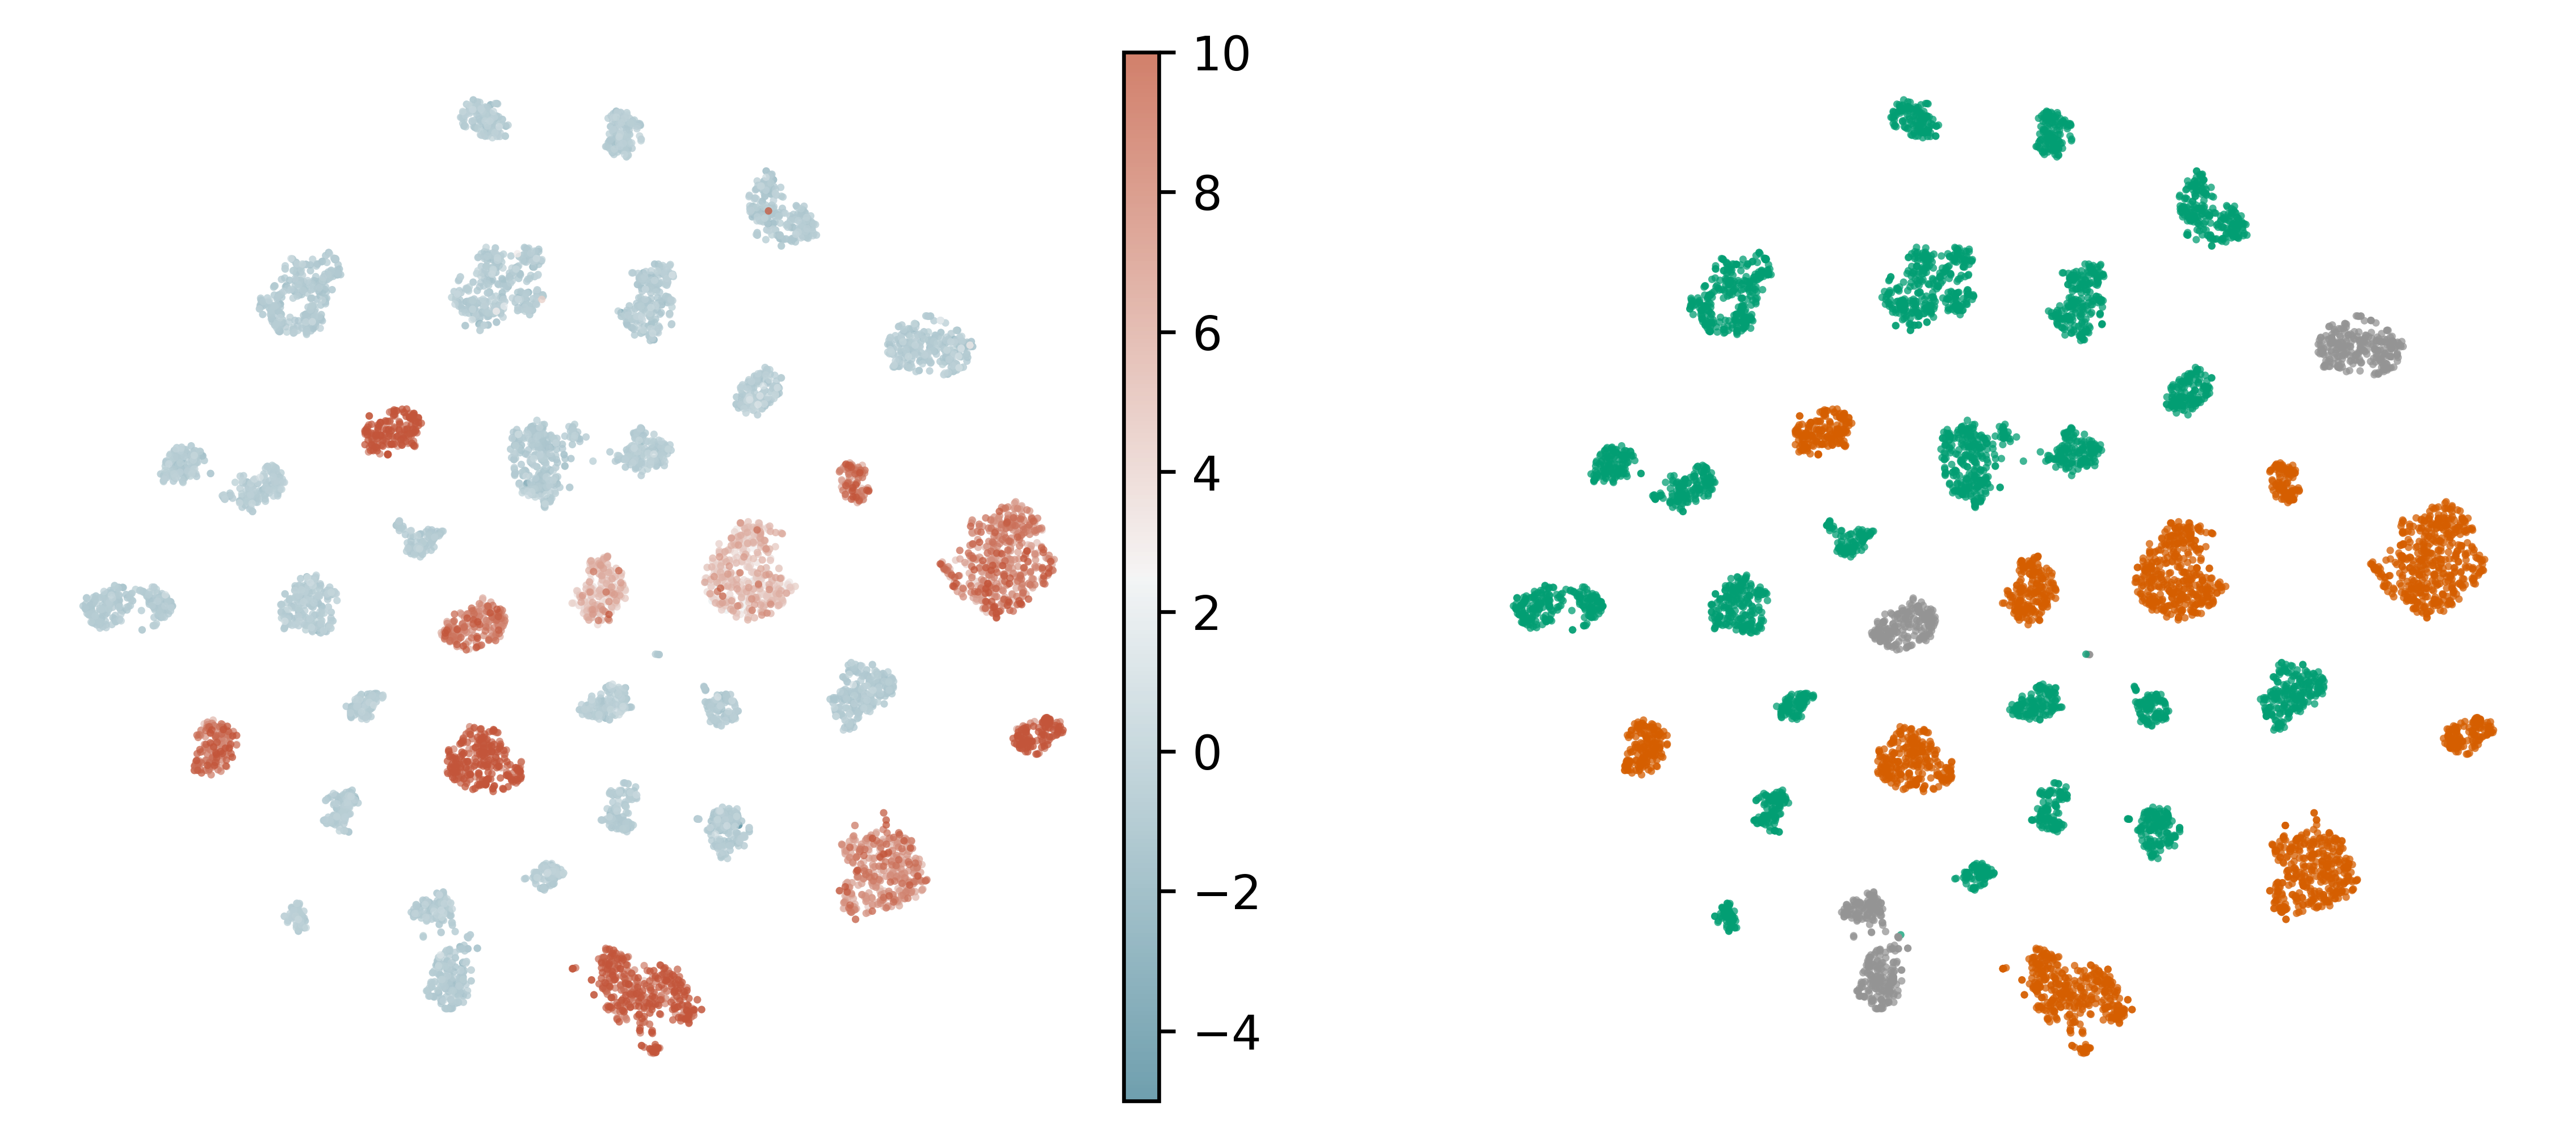

In [12]:
with plt.rc_context({"figure.dpi": (600), 'figure.figsize':(4, 4)}):

    sc.pl.tsne(adata_MSI, color=['MSI_score', 'MSI_GroundTruth',], 
            ncols=2,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
               vmin=-5, vmax=10,
                palette={ 
                    'MSI' : sns.color_palette('colorblind')[3], 
                    'MSI-L' : sns.color_palette('colorblind')[7], 
                    'MSS' : sns.color_palette('colorblind')[2], 
                    'N/A' : 'gray'
                    }, 
            # colorbar_loc=None,
            frameon=False, 
            legend_loc=None,
            alpha=0.75, 
            s=10,
            title=['', ''],
            )
plt.show()

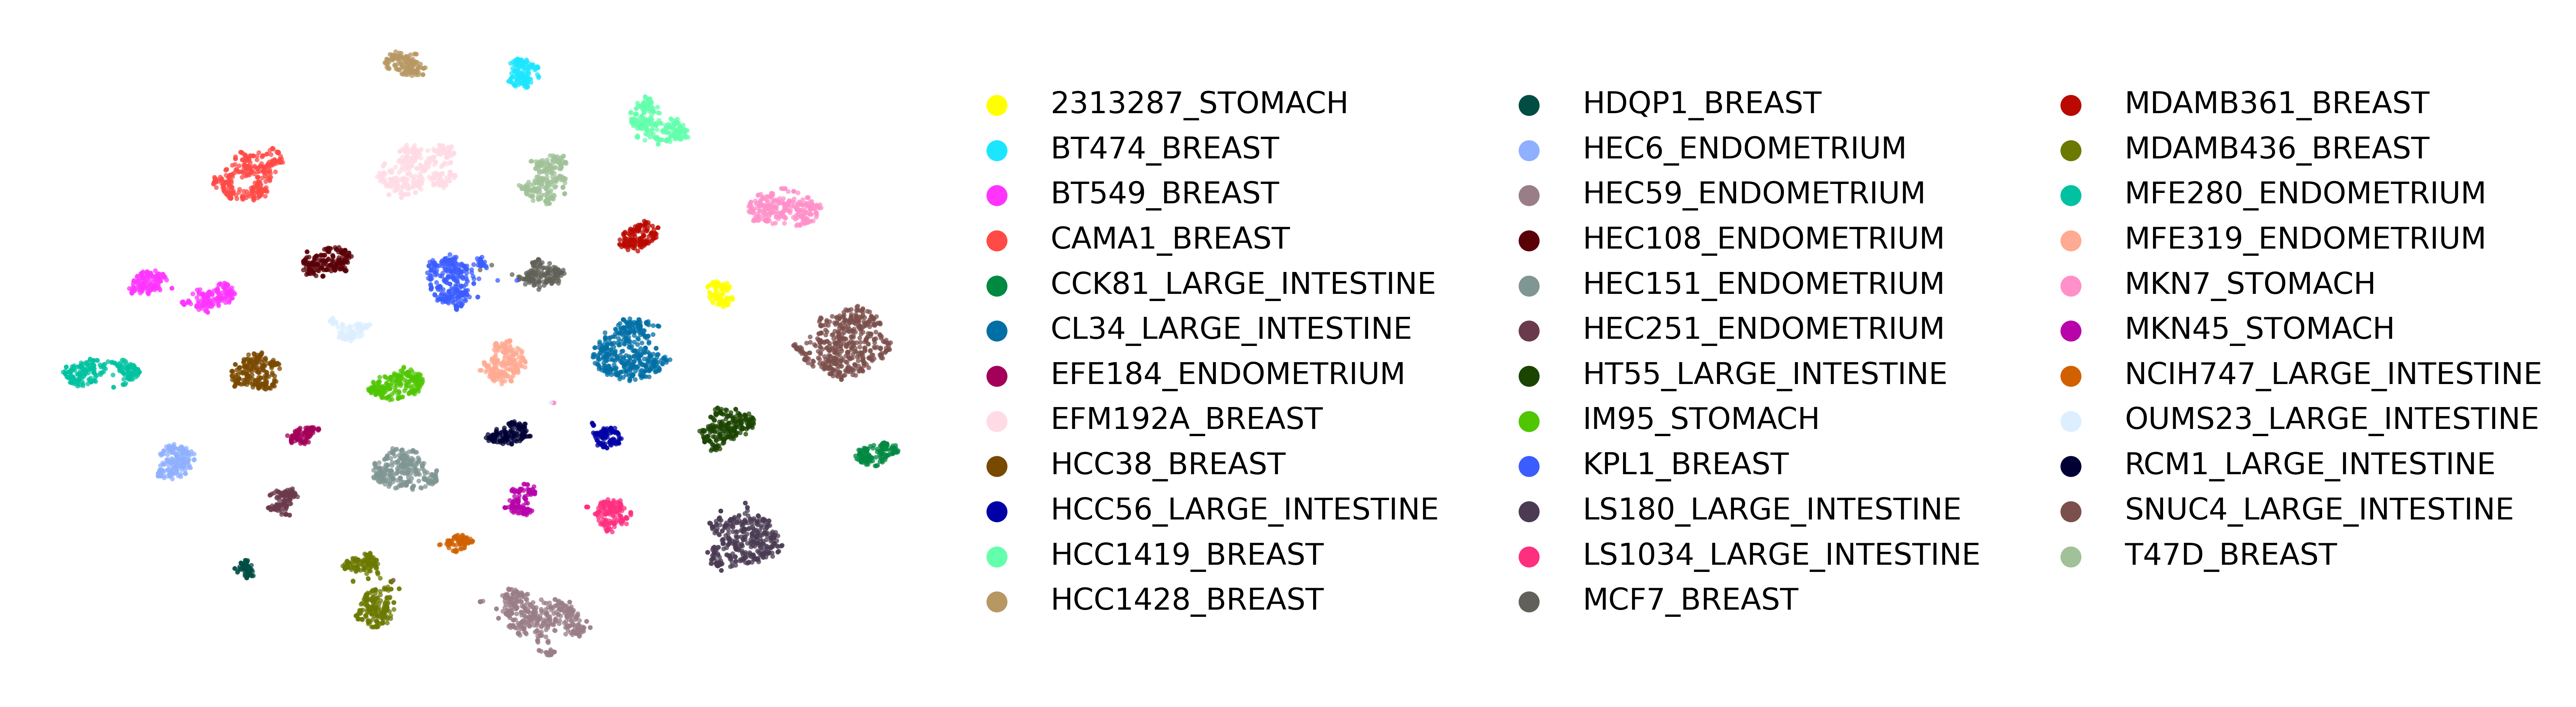

In [8]:
# sc.set_figure_params(dpi=300, frameon=False, transparent=False)

with plt.rc_context({"figure.dpi": (600), 'figure.figsize':(5.5, 4)}):

    sc.pl.tsne(adata_MSI, color=['CellLine', ], 
            colorbar_loc=None,
            frameon=False, 
            # legend_loc=None,
            alpha=0.75, 
            s=10,
            title='',
            )

## Visualize Avg. and Stdev. values (Fig. 1c, 1d)

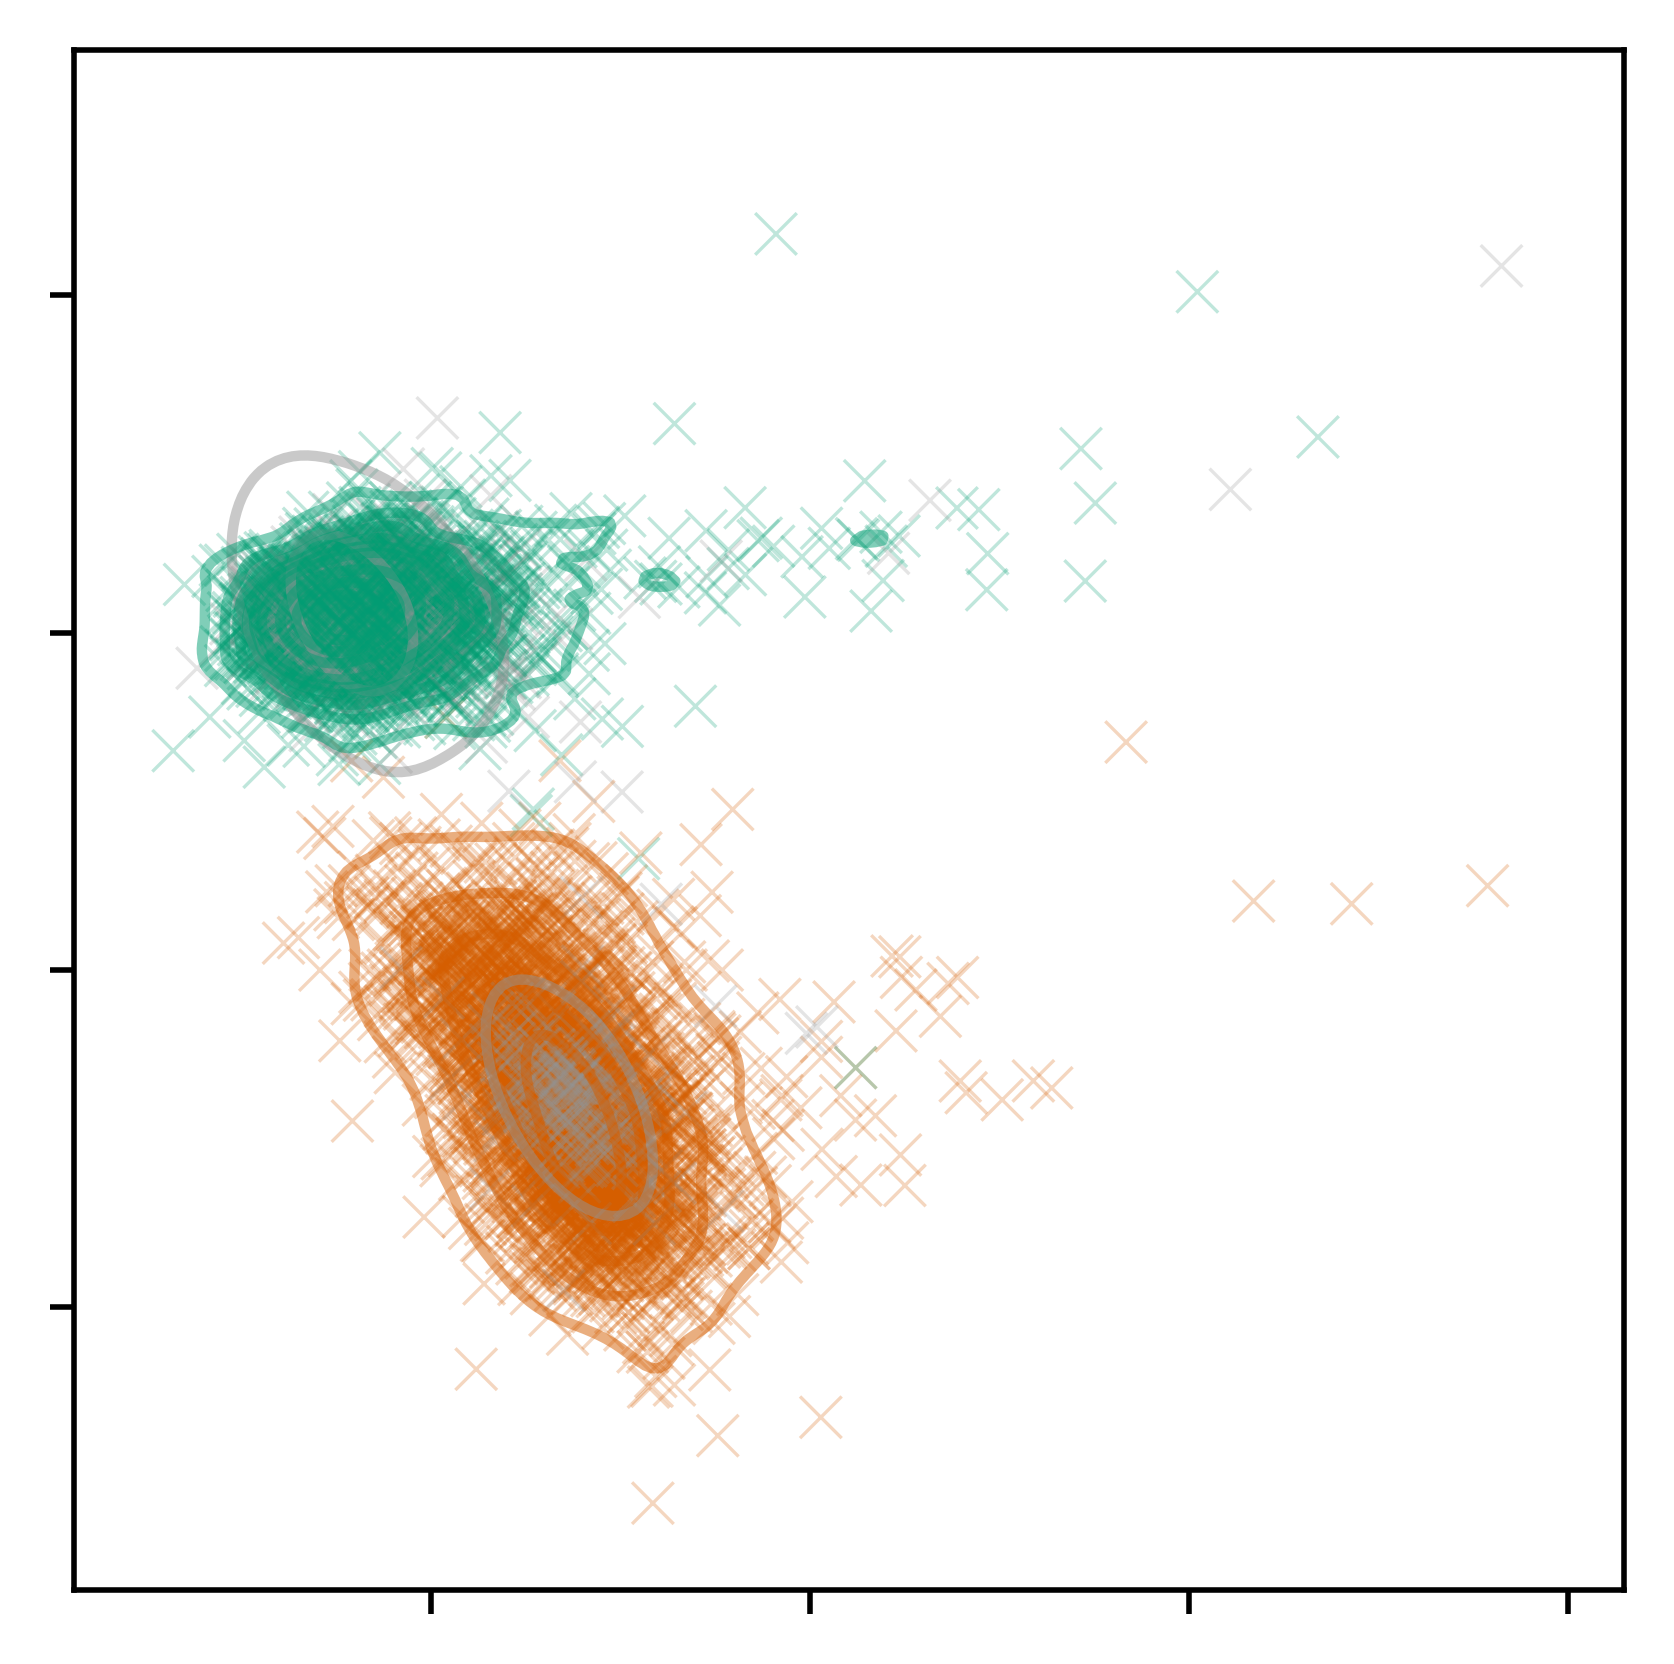

In [65]:
plt.figure(figsize=(4, 4), dpi=500)

ax = sns.kdeplot(data=adata_MSI.obs, 
                x='StdSTRDiff', 
                y='AvgSTRDiff', 
                palette={ 
                    'MSI' : sns.color_palette('colorblind')[3], 
                    'MSI-L' : sns.color_palette('colorblind')[7], 
                    'MSS' : sns.color_palette('colorblind')[2], 
                    }, 
                alpha=0.5,
                hue='MSI_GroundTruth', 
                legend=None,
                )

ax = sns.scatterplot(data=adata_MSI.obs, 
                x='StdSTRDiff', 
                y='AvgSTRDiff', 
                palette={ 
                    'MSI' : sns.color_palette('colorblind')[3], 
                    'MSI-L' : sns.color_palette('colorblind')[7], 
                    'MSS' : sns.color_palette('colorblind')[2], 
                    }, 
                    marker='x',
                alpha=0.25, 
                hue='MSI_GroundTruth', 
                legend=None,
                )

ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

plt.show()

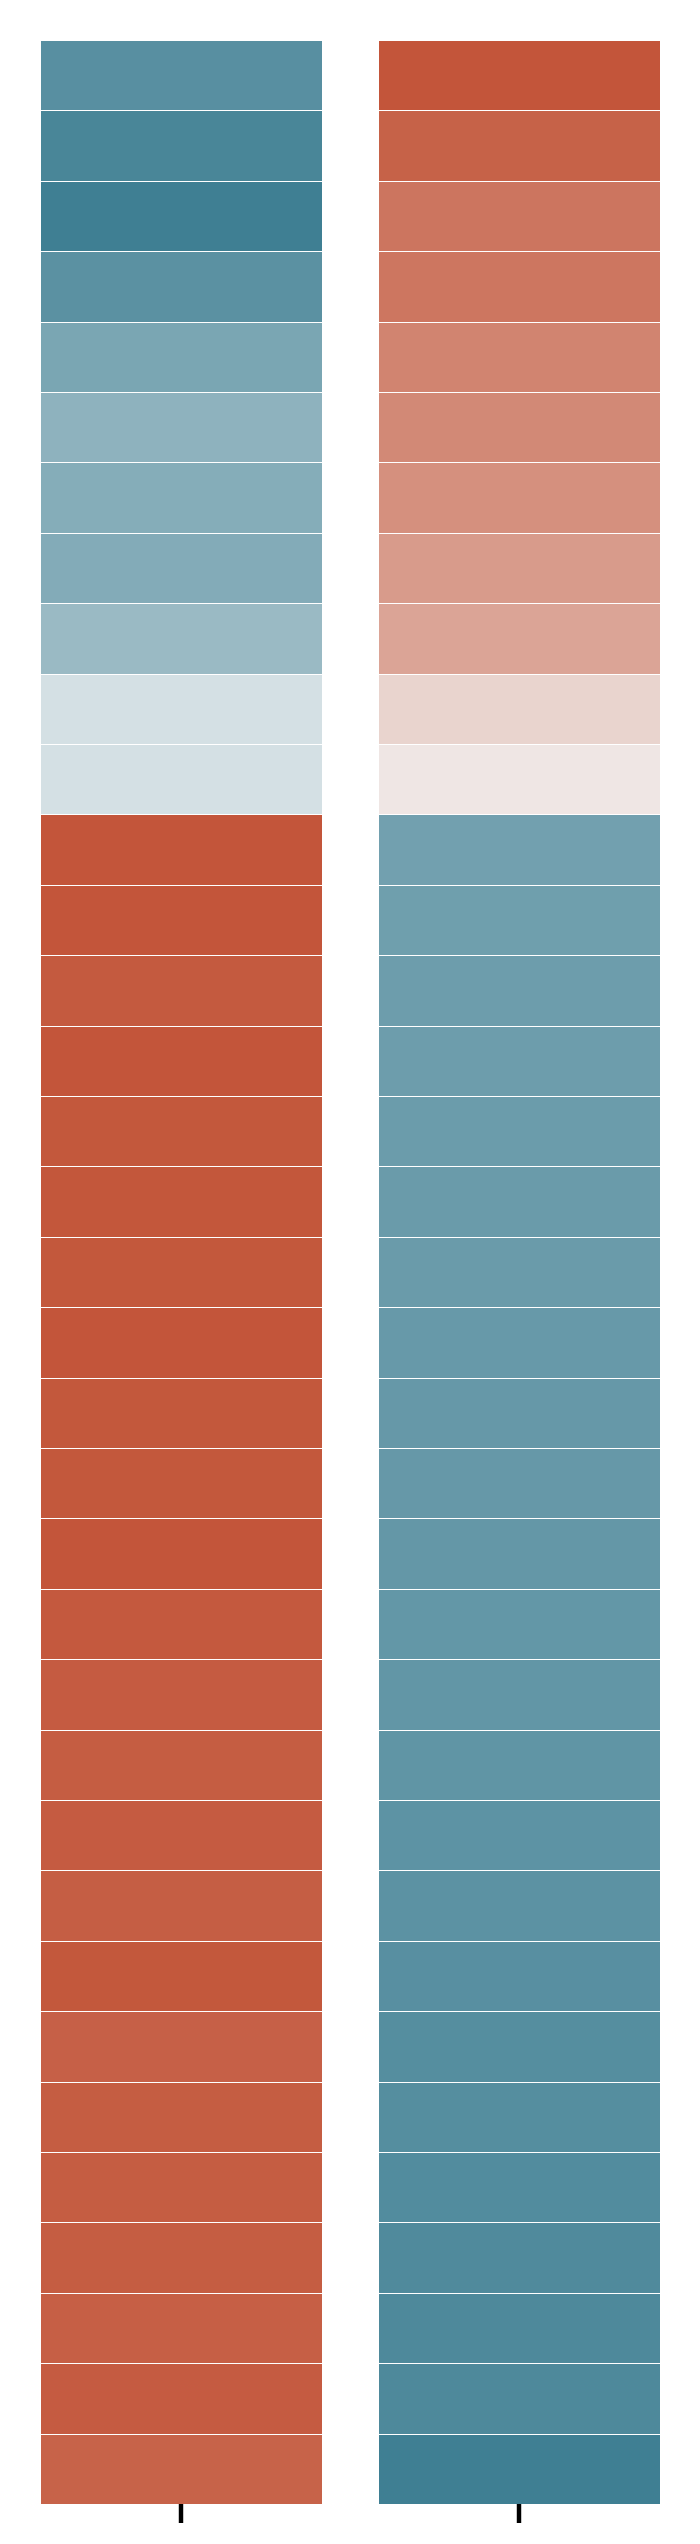

In [108]:
dict_MSI_GroundTruth_to_int = {
    'MSI' : 2,
    'MSI-L' : 1,
    'MSS' : 0,
}

HeatmapSummary = list()
for CellLine, edf in adata_MSI.obs.groupby('CellLine', observed=True):
    HeatmapSummary.append( [CellLine, dict_MSI_GroundTruth_to_int[edf.iloc[0].MSI_GroundTruth], np.mean( edf['AvgSTRDiff'] ), np.mean(edf['StdSTRDiff']) ] )

HeatmapSummary = pd.DataFrame(HeatmapSummary, columns=['CellLine', 'int_MSI_GroundTruth', 'avg', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(2, 8), dpi=400, )
ax = sns.heatmap(HeatmapSummary.sort_values('std', ascending=False)[['avg']], cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=None, linewidth=.1, ax=axes[0])
ax.set_yticklabels([]);
ax.set_yticks([]);
ax.set_xlabel('');
ax.set_xticklabels([]);

ax = sns.heatmap(HeatmapSummary.sort_values('std', ascending=False)[['std']], cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=None, linewidth=.1, ax=axes[1])
ax.set_yticklabels([]);
ax.set_yticks([]);
ax.set_xlabel('');
ax.set_xticklabels([]);
plt.show()

## Visualize MSI score through Barplot (Extended Data Fig. 1b)

In [ ]:
u, s = np.mean(adata_MSI.obs['MSI_score']), np.std(adata_MSI.obs['MSI_score'])
adata_MSI.obs['MSI_z_score'] = [ (score-u)/s for score in adata_MSI.obs['MSI_score'] ]

/tmp/ipykernel_278716/836737003.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')
/tmp/ipykernel_278716/836737003.py:2: FutureWarning: The provided callable <function mean at 0x7f4c74419120> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')


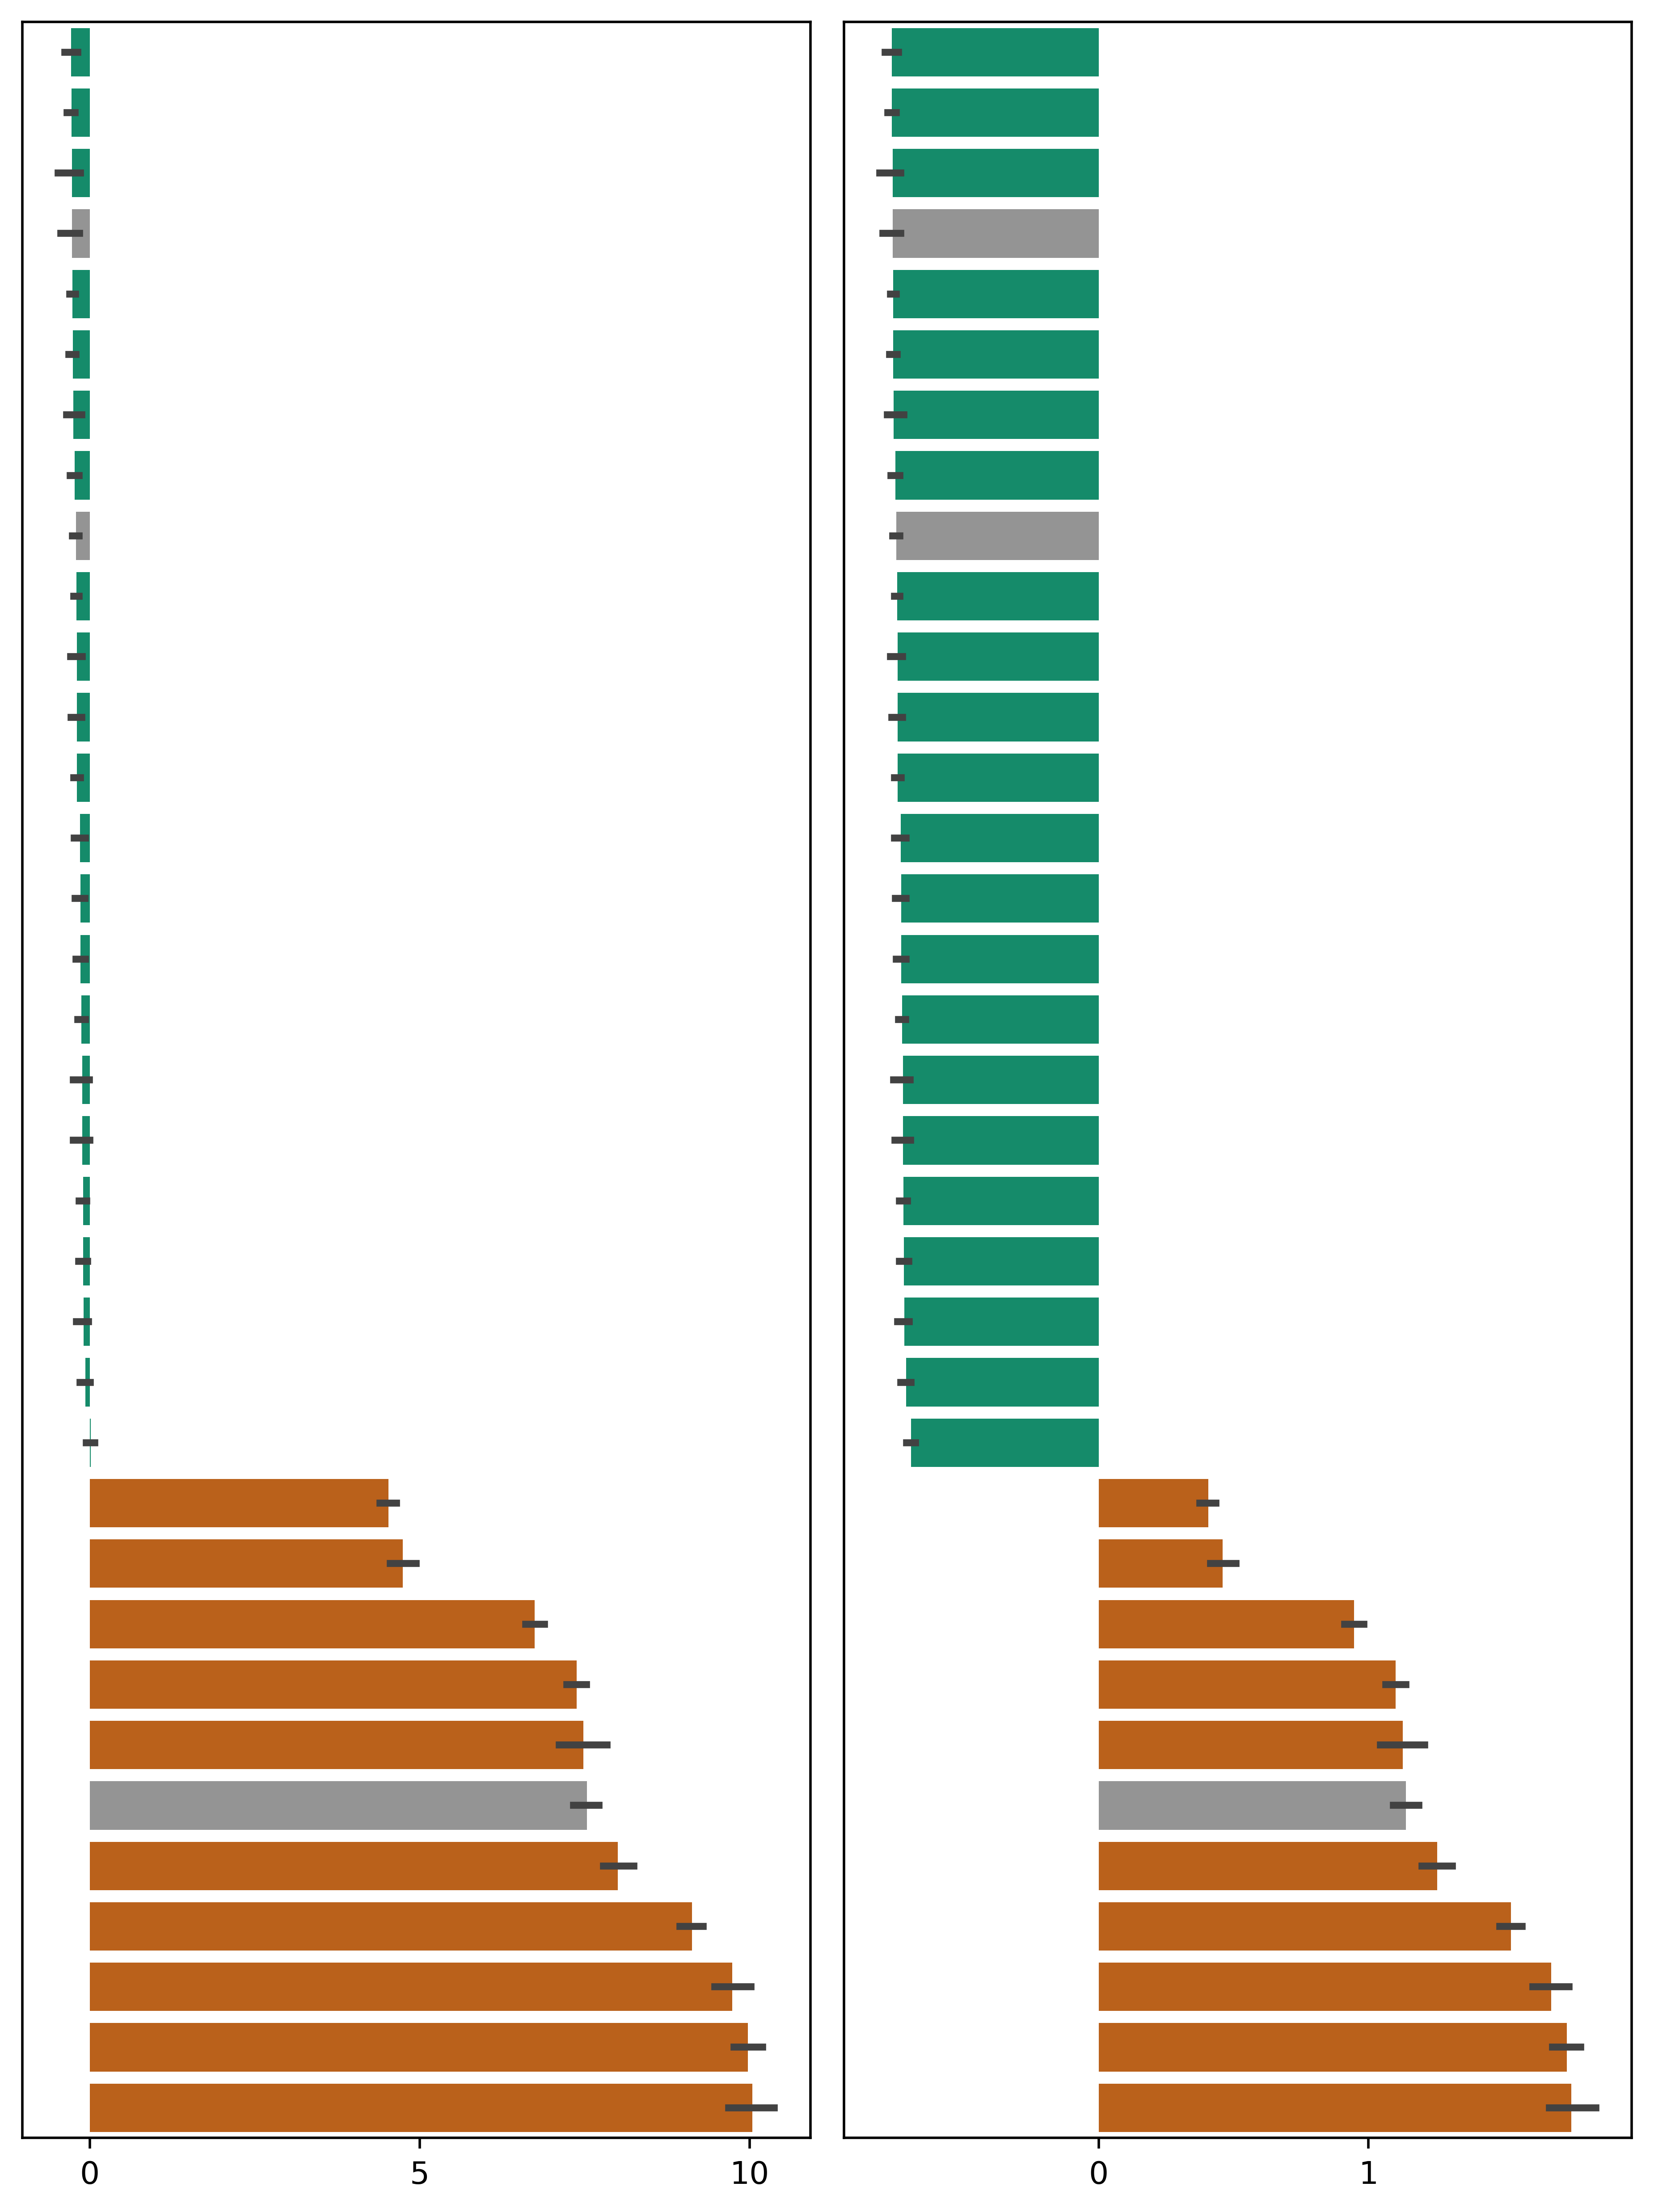

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 10), sharex=False, sharey=True, dpi=500)
OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')
ax = sns.barplot(data=adata_MSI.obs, 
            y='CellLine', 
            x='MSI_score', 
            order=OrderByMSIIntensity['CellLine'],
            hue='MSI_GroundTruth', 
            palette={ 
                'MSI' : sns.color_palette('colorblind')[3], 
                'MSI-L' : sns.color_palette('colorblind')[7], 
                'MSS' : sns.color_palette('colorblind')[2], 
                },             
            legend=None, ax=axes[0]
            )
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.set_yticklabels([]);

ax.set_xlabel('');
ax.set_ylabel('');

ax = sns.barplot(data=adata_MSI.obs, 
            y='CellLine', 
            x='MSI_z_score', 
            order=OrderByMSIIntensity['CellLine'],
            hue='MSI_GroundTruth', 
            palette={ 
                'MSI' : sns.color_palette('colorblind')[3], 
                'MSI-L' : sns.color_palette('colorblind')[7], 
                'MSS' : sns.color_palette('colorblind')[2], 
                }, 
            legend=False, 
            ax=axes[1]
            )
ax.set_yticks([]);
ax.set_yticklabels([]);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.set_xlabel('');
ax.set_ylabel('');

fig.tight_layout();
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='')
plt.show()

## Number of microsatellite loci assessed (Extended Data Fig. 1e)

/tmp/ipykernel_278716/1731126518.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine_Name'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')
/tmp/ipykernel_278716/1731126518.py:2: FutureWarning: The provided callable <function mean at 0x7f4c74419120> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine_Name'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')


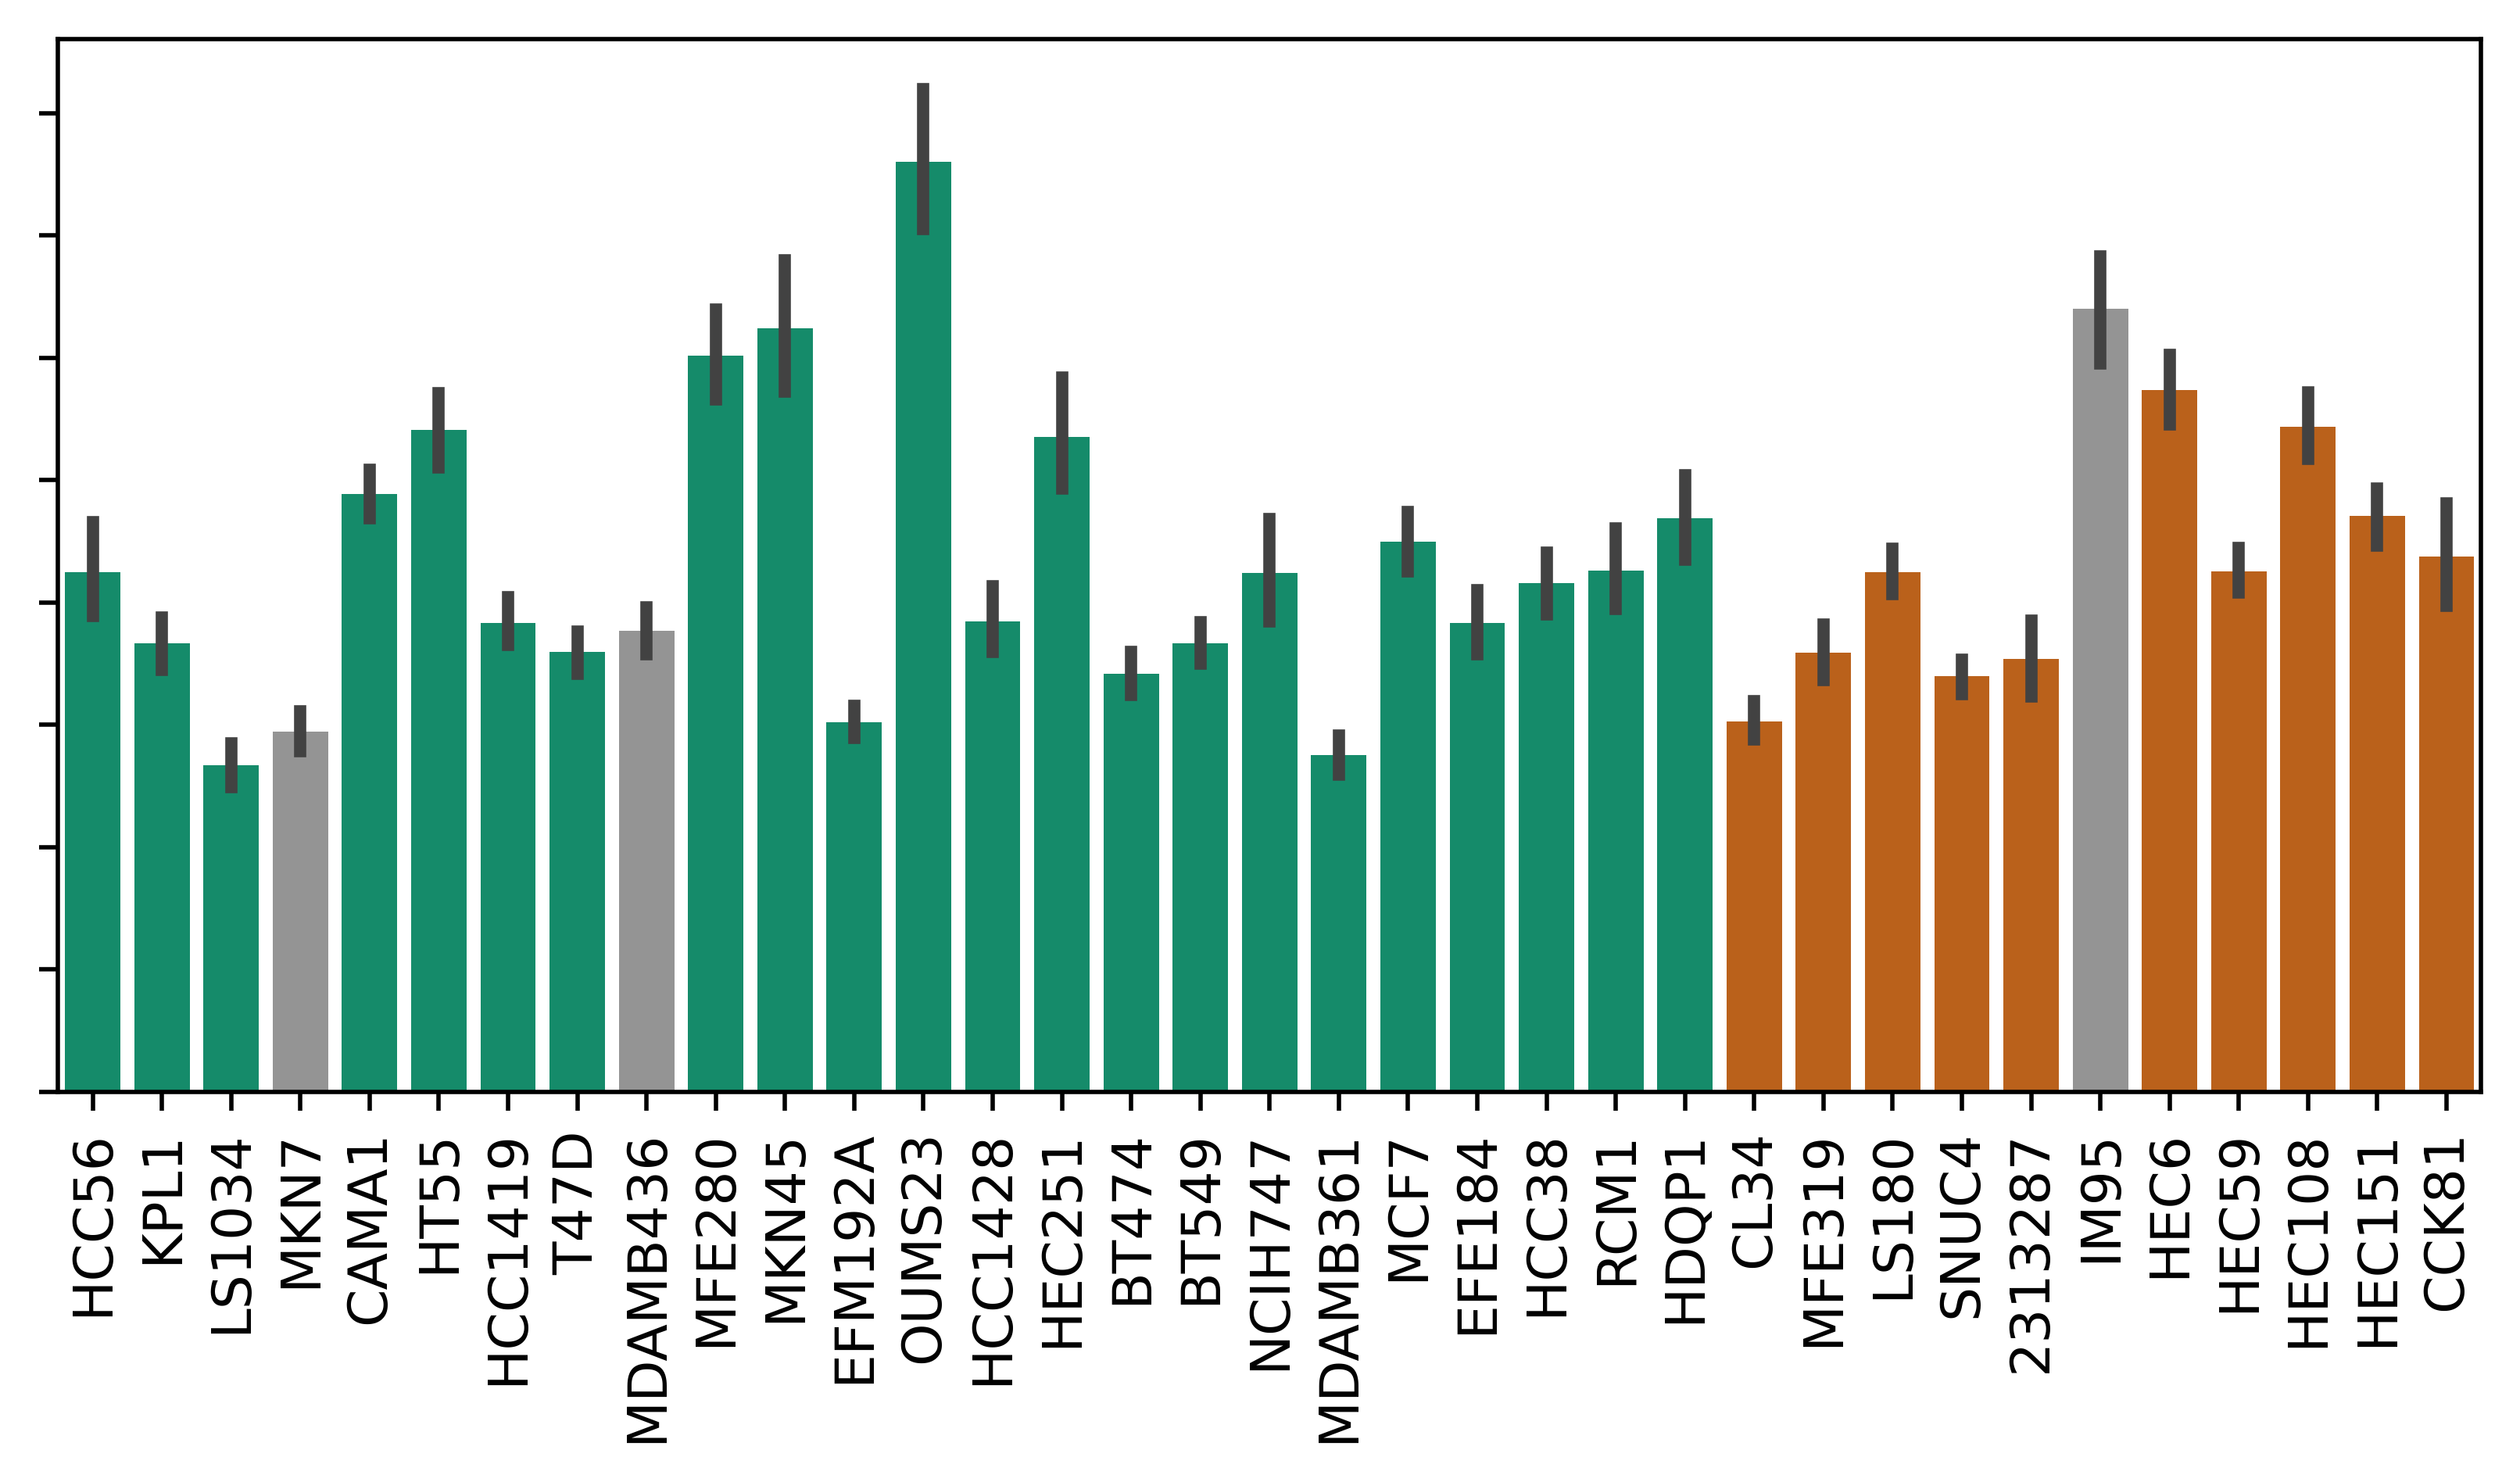

In [63]:
plt.figure(figsize=(8, 3.5), dpi=500)
OrderByMSIIntensity = adata_MSI.obs.groupby(['CellLine_Name'])['MSI_score'].aggregate(np.mean).reset_index().sort_values('MSI_score')
ax = sns.barplot(data=adata_MSI.obs, 
            x='CellLine_Name', 
            y='NumSTRLoci', 
            order=OrderByMSIIntensity['CellLine_Name'],
            hue='MSI_GroundTruth', 
            palette={ 
                'MSI' : sns.color_palette('colorblind')[3], 
                'MSI-L' : sns.color_palette('colorblind')[7], 
                'MSS' : sns.color_palette('colorblind')[2], 
                'N/A' : 'gray'
                },             
            legend=None, 
            )
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_yticklabels([]);
ax.set_ylabel('');
# ax.set_xticklabels([]);
plt.xticks(rotation=90)
ax.set_xlabel('');
plt.show()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='')

## Specificity/Sensitivity of NanoMnT-scMSI (Extended Data Fig. 1c)

In [112]:
threshold_start_value = -1
threshold_final_value = 10

scMSI_IdentificationResults = list() 

for i in range(0, 100*(threshold_final_value-threshold_start_value)+1):
    increment = i*0.01
    threshold = threshold_start_value + increment
    
    TP, TN, FP, FN = 0, 0, 0, 0
    
    for tup in adata_MSI.obs[adata_MSI.obs['MSI_GroundTruth']!='MSI-L'].itertuples():
        if tup.MSI_GroundTruth == 'MSI':
            if tup.MSI_score >= threshold:
                TP += 1
            else:
                FN += 1
        
        elif tup.MSI_GroundTruth == 'MSS':
            if tup.MSI_score >= threshold:
                FP += 1
            else:
                TN += 1

    scMSI_IdentificationResults.append( [threshold, TP/(TP+FN), TN/(TN+FP)] )
    
scMSI_IdentificationResults = pd.DataFrame(scMSI_IdentificationResults, columns=['threshold', 'sensitivity', 'specificity'])
scMSI_IdentificationResults.head(2)

threshold  sensitivity  specificity
0      -1.00          1.0     0.035666
1      -0.99          1.0     0.036477

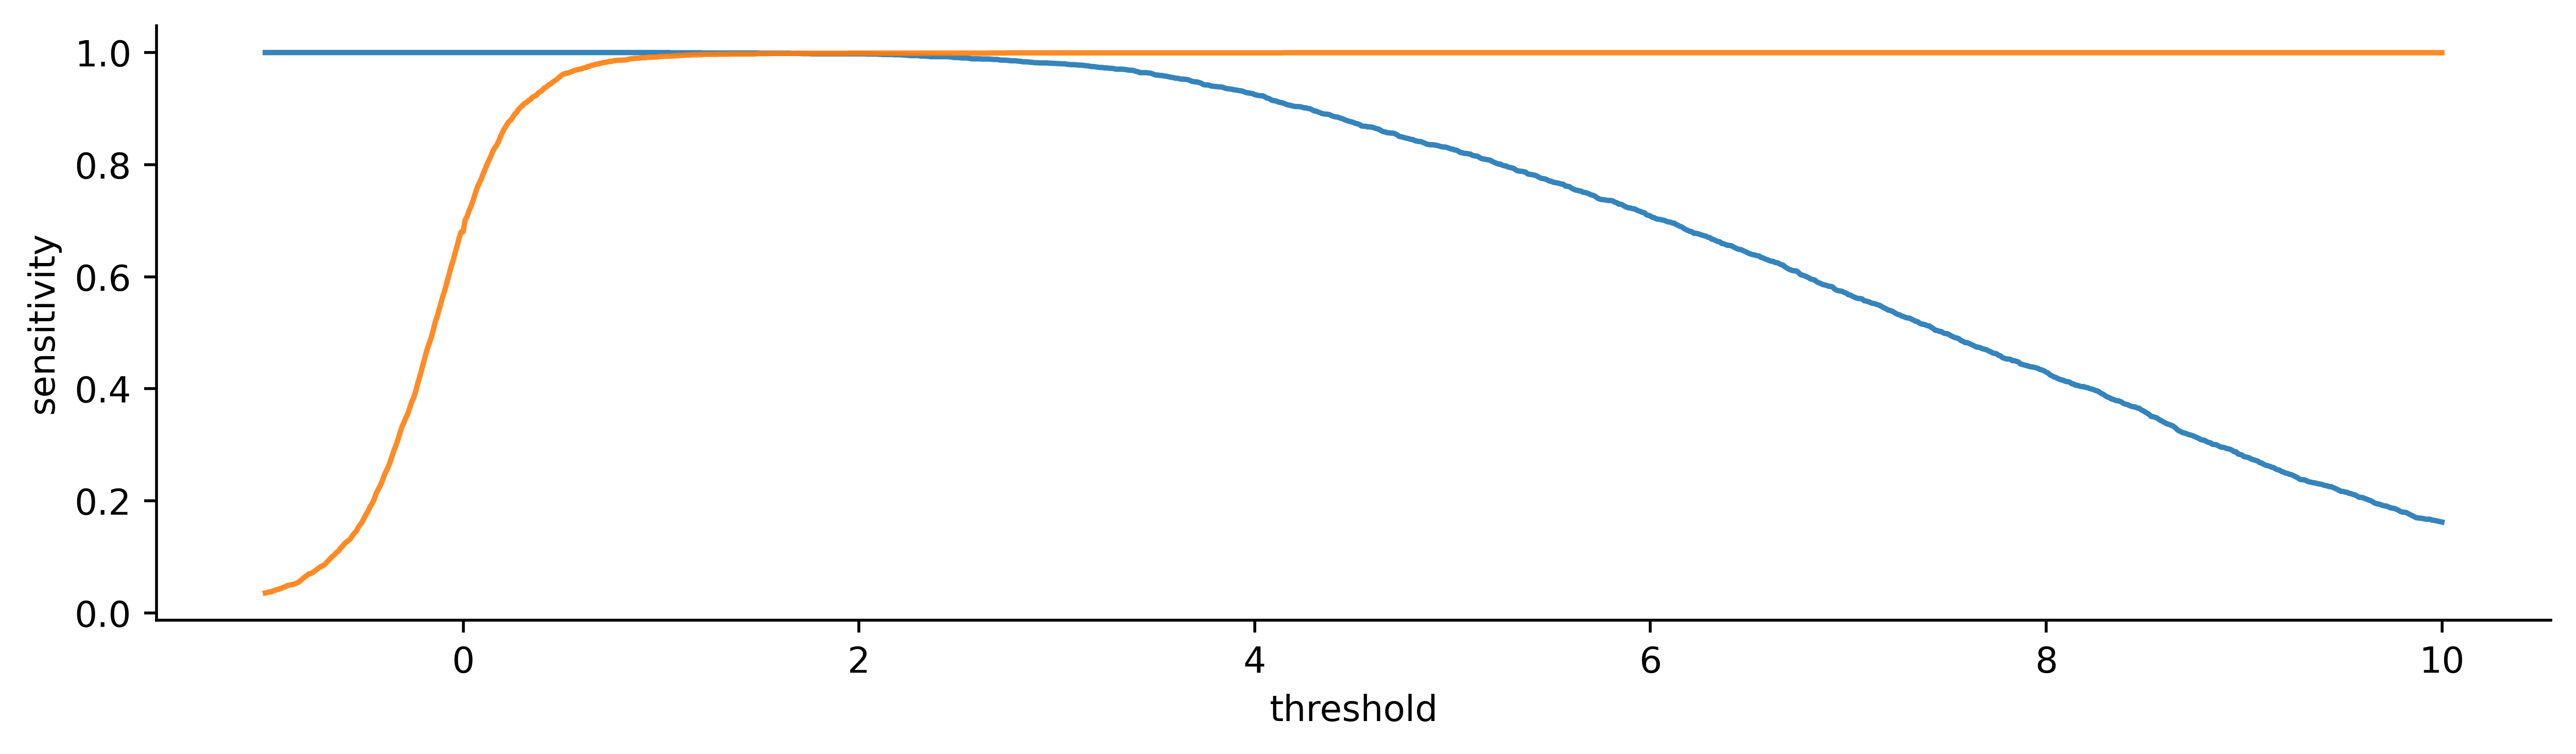

In [125]:
plt.figure(figsize=(12, 3), dpi=500)
sns.lineplot(data=scMSI_IdentificationResults, x='threshold', y='sensitivity', alpha=0.9,)
ax = sns.lineplot(data=scMSI_IdentificationResults, x='threshold', y='specificity', alpha=0.9,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);

sns.despine(top=True, right=True)
plt.show()


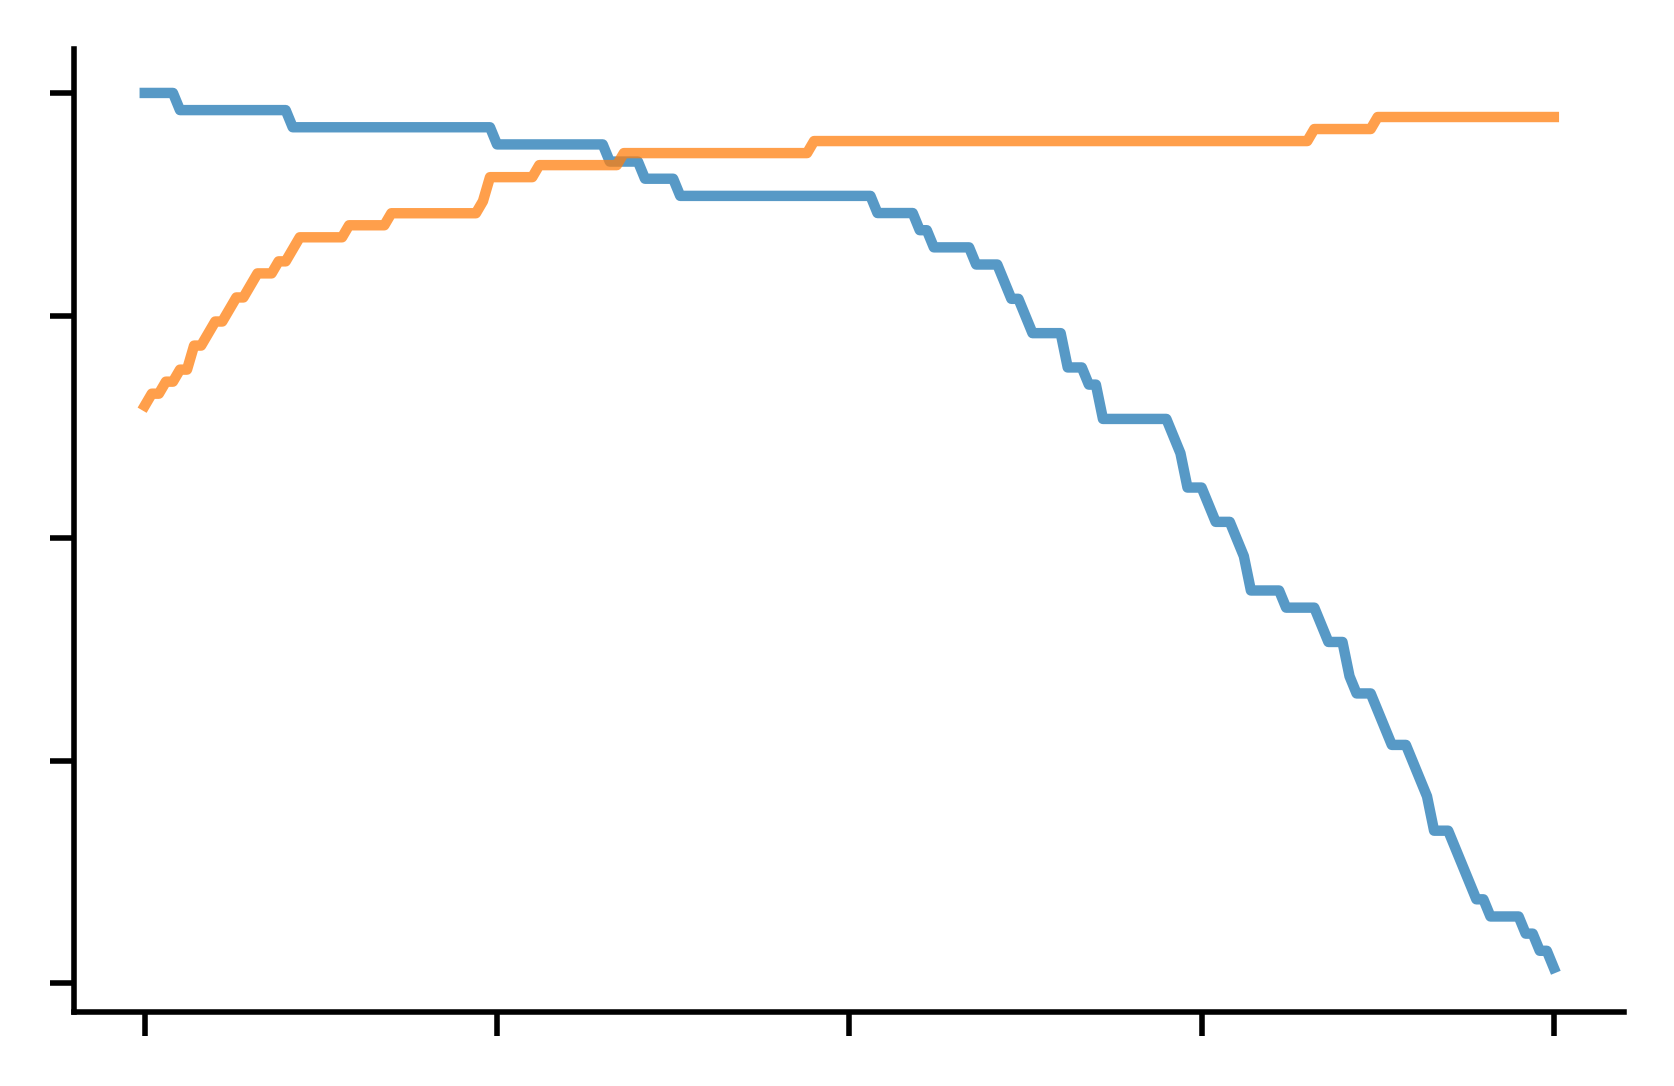

In [133]:
plt.figure(figsize=(4, 2.5), dpi=500)
ax = sns.lineplot(data=scMSI_IdentificationResults[(scMSI_IdentificationResults['threshold']>=1) & (scMSI_IdentificationResults['threshold']<=3)], x='threshold', y='sensitivity', 
                  alpha=0.75,)
ax = sns.lineplot(data=scMSI_IdentificationResults[(scMSI_IdentificationResults['threshold']>=1) & (scMSI_IdentificationResults['threshold']<=3)], x='threshold', y='specificity',
                  alpha=0.75,)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');
sns.despine()
plt.show()

In [138]:
scMSI_IdentificationResults['diff'] = [ abs(tup.sensitivity-tup.specificity) for tup in scMSI_IdentificationResults.itertuples() ]
scMSI_IdentificationResults.sort_values('diff').head(2)

threshold  sensitivity  specificity     diff
266       1.66     0.998459     0.998379  0.00008
267       1.67     0.998459     0.998379  0.00008

## Influence of MS loci counts on MSI score (Extended Data Fig. 1d)

SignificanceResult(statistic=0.24688694568701694, pvalue=2.4489624149997477e-37)
SignificanceResult(statistic=-0.009230105942795793, pvalue=0.574563347064573)


<Figure size 2000x1400 with 0 Axes>

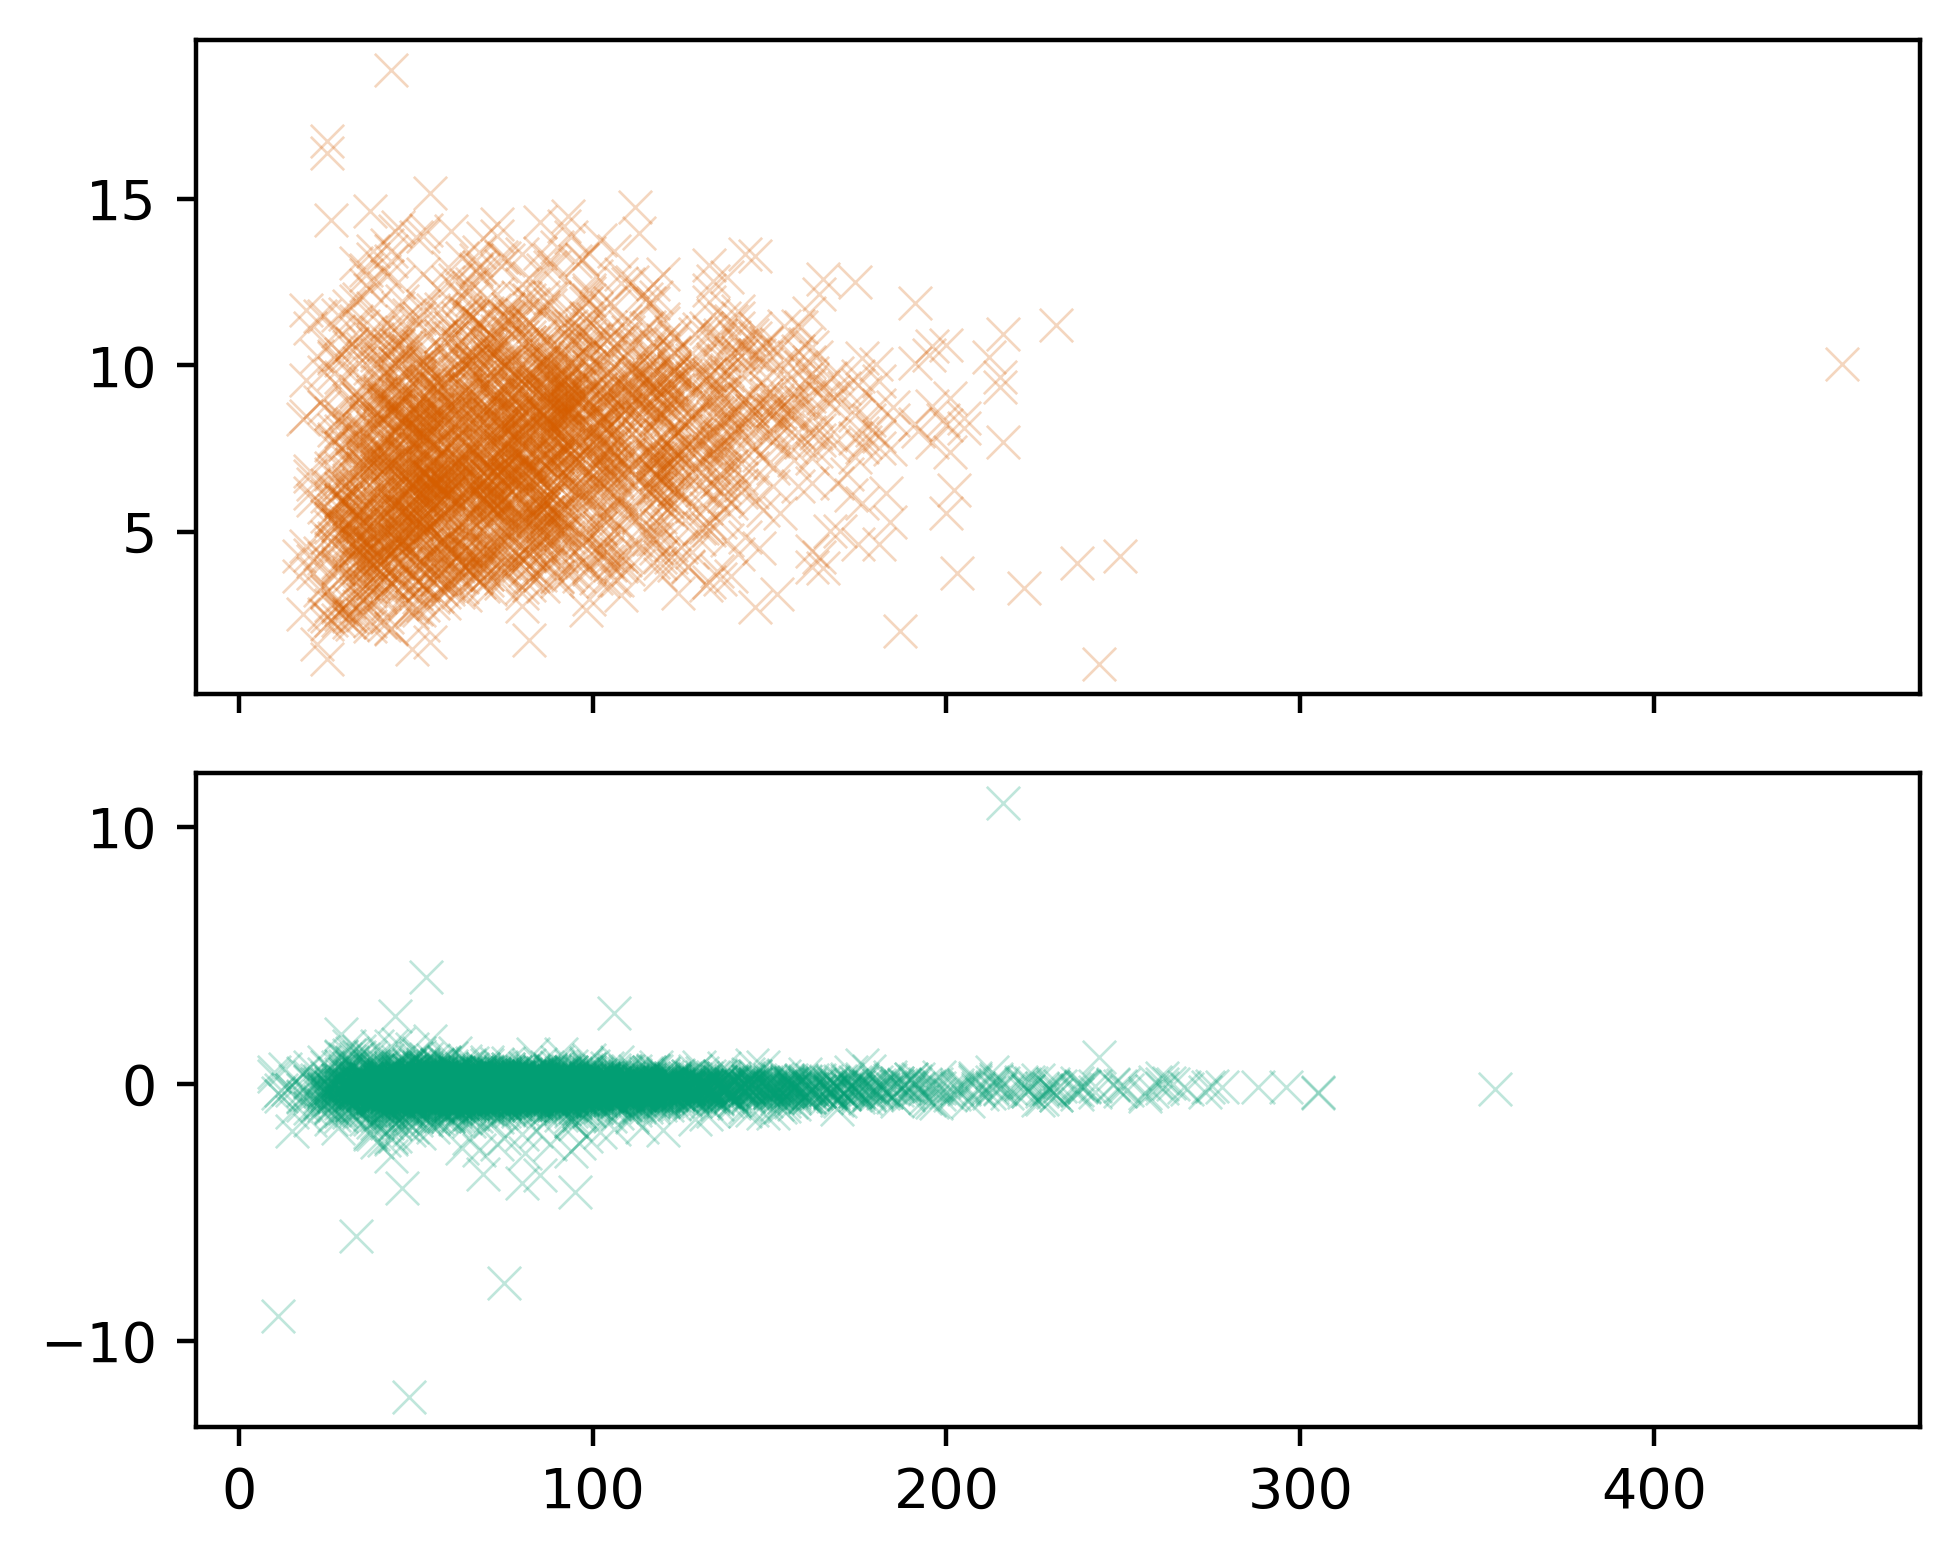

In [151]:
import scipy.stats 
plt.figure(figsize=(5, 3.5), dpi=400)
fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True, dpi=400)
adata_obs_oi = adata_MSI.obs[adata_MSI.obs['MSI_GroundTruth']=='MSI']
ax1 = sns.scatterplot(data=adata_obs_oi, x='NumSTRLoci', y='MSI_score', marker='x', alpha=0.25, color=sns.color_palette('colorblind')[3], ax=axes[0])
ax1.set_xlabel('')
ax1.set_ylabel('')
# ax1.set_xticklabels([]);
# ax1.set_yticklabels([]);
print(scipy.stats.spearmanr(adata_obs_oi['NumSTRLoci'], adata_obs_oi['MSI_score']))

adata_obs_oi = adata_MSI.obs[adata_MSI.obs['MSI_GroundTruth']=='MSS']
ax2 = sns.scatterplot(data=adata_obs_oi, x='NumSTRLoci', y='MSI_score', marker='x', alpha=0.25, color=sns.color_palette('colorblind')[2], ax=axes[1])
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.set_xticklabels([]);
# ax2.set_yticklabels([]);
fig.tight_layout();
print(scipy.stats.spearmanr(adata_obs_oi['NumSTRLoci'], adata_obs_oi['MSI_score']))

plt.show()